Loading model from model_final_unet2.pth to cuda...
Model loaded successfully.
Loading sample data (image: 'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\pictures\01_dr.JPG', label: 'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\manual\01_dr.tif')...


C:\Users\Gienon\AppData\Local\Temp\ipykernel_23280\1096949139.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Performing inference...
Displaying results...


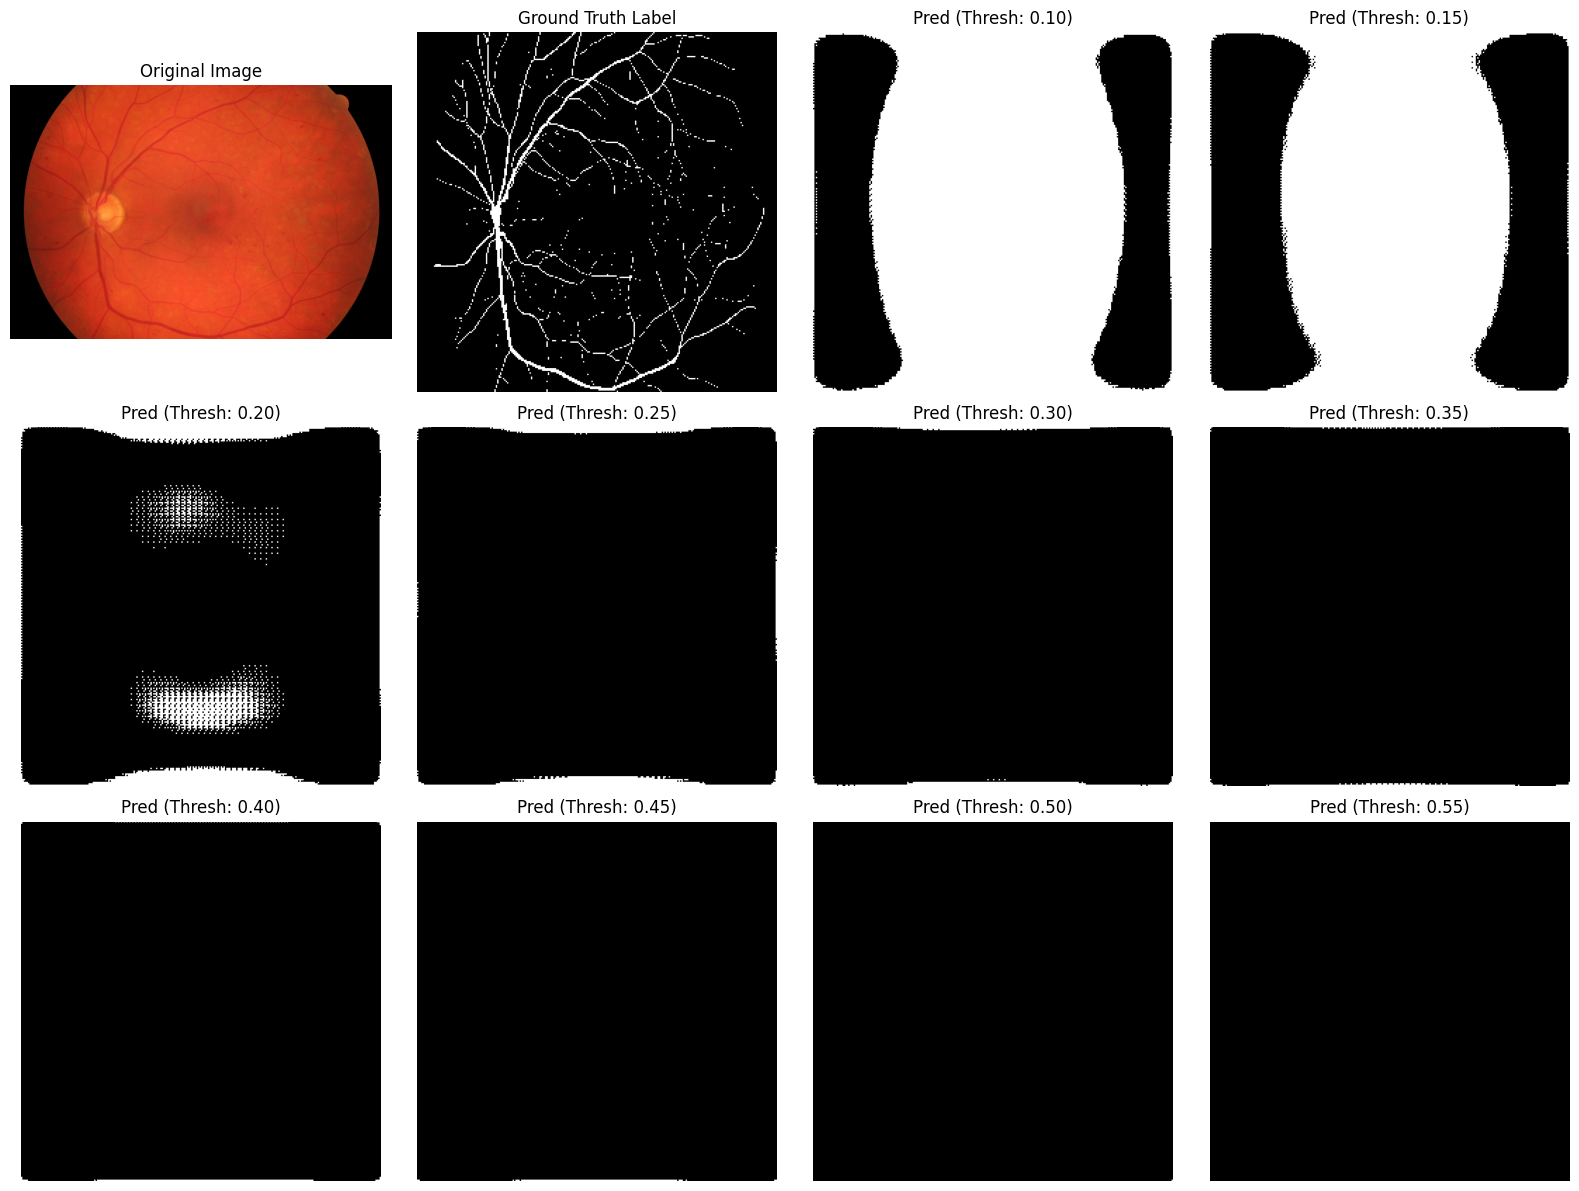

Output probabilities tensor shape (after processing, on CPU): torch.Size([1, 256, 256])
Output probabilities min: 0.0028, max: 0.5032, mean: 0.1332


In [1]:
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from DLModel2 import UNet # Import UNet from DLModel2.py

# --- Configuration ---
MODEL_PATH = 'model_final_unet2.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_CHANNELS = 3  # Number of input channels (RGB) - Should match model's training
N_CLASSES = 1   # Number of output classes (binary segmentation) - Should match model's training
IMG_SIZE = (256, 256) # Target image size for the model - Should match model's training

# TODO: Replace with actual paths to your sample image and label
# For example:
# SAMPLE_IMAGE_PATH = r'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\pictures\01_dr.JPG'
# SAMPLE_LABEL_PATH = r'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\manual\01_dr.tif'
SAMPLE_IMAGE_PATH = r'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\pictures\01_dr.JPG'
SAMPLE_LABEL_PATH = r'f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\images\manual\01_dr.tif'


# --- Helper function to load and preprocess image ---
# This function is specific to this notebook for inference and visualization
def load_and_preprocess_image_notebook(image_path, label_path=None, img_size=(256, 256)):
    try:
        image = Image.open(image_path).convert('RGB' if N_CHANNELS == 3 else 'L')
    except FileNotFoundError:
        print(f"Warning: Image file not found at '{image_path}'. Using a dummy RGB image.")
        array = np.random.randint(0, 256, (img_size[0], img_size[1], N_CHANNELS), dtype=np.uint8)
        if N_CHANNELS == 1: array = array[:,:,0] # Should not happen if N_CHANNELS is 3
        image = Image.fromarray(array)

    pil_original_image = image.copy()

    transform_list = [T.Resize(img_size), T.ToTensor()]
    # Normalization should match what was used during training if any.
    # The UNet in DLModel2.py normalizes to [0,1] by dividing by 255.0. ToTensor() does this.
    # If DLModel2.py's load_and_preprocess_image had other normalization (e.g. T.Normalize), add it here.
    preprocess_transform = T.Compose(transform_list)
    image_tensor = preprocess_transform(image)

    pil_label_image = None
    if label_path:
        try:
            label = Image.open(label_path).convert('L') # Grayscale for mask
            pil_label_image = label.copy().resize(img_size, Image.NEAREST) # Resize for display consistency
        except FileNotFoundError:
            print(f"Warning: Label file not found at '{label_path}'. No ground truth label will be shown.")
    
    if pil_label_image is None: # If label_path was None or file not found
        print("Using a dummy label for display (all zeros).")
        dummy_label_array = np.zeros((img_size[0], img_size[1]), dtype=np.uint8)
        pil_label_image = Image.fromarray(dummy_label_array)

    return pil_original_image, image_tensor, pil_label_image

# --- Load Model ---
print(f"Loading model from {MODEL_PATH} to {DEVICE}...")
try:
    # Instantiate the UNet model imported from DLModel2.py
    model = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at '{MODEL_PATH}'. Please check the path.")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure:")
    print("1. 'DLModel2.py' is in the same directory or Python path.")
    print("2. The UNet class in 'DLModel2.py' matches your saved model's architecture.")
    print(f"3. N_CHANNELS ({N_CHANNELS}) and N_CLASSES ({N_CLASSES}) match the model's training.")
    print(f"4. The MODEL_PATH ('{MODEL_PATH}') is correct.")
    raise RuntimeError("Failed to load the model. Halting execution.") from e

# --- Load Sample Data ---
print(f"Loading sample data (image: '{SAMPLE_IMAGE_PATH}', label: '{SAMPLE_LABEL_PATH}')...")
original_pil_img, img_tensor, original_pil_lbl = \
    load_and_preprocess_image_notebook(SAMPLE_IMAGE_PATH, SAMPLE_LABEL_PATH, img_size=IMG_SIZE)

# --- Perform Inference ---
print("Performing inference...")
input_batch = img_tensor.unsqueeze(0).to(DEVICE) # Add batch dimension

with torch.no_grad():
    output = model(input_batch) # Output: [B, N_CLASSES, H, W]

# Process output:
# For N_CLASSES=1 (binary segmentation with sigmoid), output is already probabilities [B, 1, H, W]
output_probs_cpu = output.squeeze(0).cpu() # Remove batch, move to CPU -> [C, H, W] or [H,W] if C=1

# --- Display Results ---
print("Displaying results...")
thresholds = [0.1 + i * 0.05 for i in range(10)] # Thresholds: 0.1, 0.15, ..., 0.55

num_images_to_show = 2 + len(thresholds)
cols = 4 
rows = (num_images_to_show + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.ravel() # Flatten the array of axes

# 1. Original Image
axes[0].imshow(original_pil_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# 2. Ground Truth Label
axes[1].imshow(original_pil_lbl, cmap='gray')
axes[1].set_title('Ground Truth Label')
axes[1].axis('off')

# 3. Predicted Masks with different thresholds
# Squeeze to [H, W] if N_CLASSES is 1, otherwise you might need to select a channel
display_probs_np = output_probs_cpu.squeeze().numpy() 

for i, thresh in enumerate(thresholds):
    pred_mask_np = (display_probs_np >= thresh).astype(np.uint8)
    ax_idx = i + 2
    if ax_idx < len(axes):
        axes[ax_idx].imshow(pred_mask_np, cmap='gray', vmin=0, vmax=1)
        axes[ax_idx].set_title(f'Pred (Thresh: {thresh:.2f})')
        axes[ax_idx].axis('off')

# Hide any unused subplots
for j in range(num_images_to_show, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Print some info about the output probabilities
print(f"Output probabilities tensor shape (after processing, on CPU): {output_probs_cpu.shape}")
if output_probs_cpu.numel() > 0:
    min_val = output_probs_cpu.min().item()
    max_val = output_probs_cpu.max().item()
    mean_val = output_probs_cpu.mean().item()
    print(f"Output probabilities min: {min_val:.4f}, max: {max_val:.4f}, mean: {mean_val:.4f}")
    if not (0 <= min_val <= 1 and 0 <= max_val <= 1):
        print("Warning: Output probabilities are not strictly in the [0,1] range. This might indicate an issue if Sigmoid was expected to constrain them.")
else:
    print("Output probabilities tensor is empty.")

